# Eksploracja tekstu

Ta część praktycznego wykorzystania metod eksploracji danych związana będzie z analizą tekstu. 

W tym celu skorzystamy z bazy danych przechowującej posty z serwisu Reddit. Analizę podzielimy na następujące kroki:

1. formatowanie danych
2. wstępna analiza, oczyszczenie i statystyki
3. eksploracja danych z wykorzystaniem biblioteki pandas
4. wykorzystanie technik bazujących na uczeniu bez nadzoru 

Dlaczego eksploracja tekstu jest tak ważna? Ponieważ można w łatwy sposób zautomatyzować klasyfikację postów, zgłaszać nadużycia lub treści, które nie powinny się w danym miejscu znaleźć. Dodatkowo - łatwo będzie analizować, jakie tematy są poruszane przez użytkowników, dbać o prządek postów i dodatkowo - zapobiegać działalności botów.

Na początek trochę informacji na temat danych tekstowych - dla ustalenia uwagi. Dane składają się z postów, które opublikowane na około 3 000 subredditach, z czego w każdym z nich jest ponad 1000 postów. Dane związane są głównie z tematyką budowy komputerów, ich modernizacją oraz grami komputerowymi. Wśród postów są jednak również takie, które zupełnie nie pasują do tematyki oraz posty opublikowane definitywnie przez boty.

Dane potrzebne do pracy ściągnięte zostały z serwisu kaggle (https://www.kaggle.com/mswarbrickjones/reddit-selfposts/data) - liczą sobie one ponad 800 MB. Proszę je ściągnąć przed przystąpieniem do wykonywania kodu w komórkach poniżej.

Dla osób, któe nie chcą logować się do serwisu kaggle - zamieszczam skompresowany plik na swoim serwerze:

http://storage.ablewski.pl/public/umk/WDDM2020/rspct.tsv

Drugi plik z danymi, zawierający informacje o subredditach jest znacznie mniejszy (200 kB) i znajduje się w repozytorium.

## Przygotowanie danych

In [2]:
import pandas as pd
df = pd.read_csv("./Dane/rspct.tsv", sep='\t')
df

,id,subreddit,title,selftext
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,..."
...,...,...,...,...
1012995,5r9k4h,MSLGame,Is this months rebirth and dungeon astro's wor...,I looking on what to evo3 farm next and was ex...
1012996,6529fp,CrohnsDisease,I might need a Medical leave from grad school,Has anyone here ever needed a medical leave fr...
1012997,7tiyzx,HongKong,Police harassing ethnic minorities in Hong Kong,I thought I'd make this post so that more peop...
1012998,664ha3,yorku,SU EECS 2030 and EECS 2021 - need advice,"Hi, I just finished 1st year EECS courses and ..."


In [4]:
import sqlite3
con = sqlite3.connect('./selfposts.db')
# poniższą linię wykonujemy tylko raz
#pd.read_csv('./Dane/subreddit_info.csv').to_sql("categories", con)

Mamy wczytane potrzebne dane - część z nich jest po prostu DataFramem z biblioteki pandas, a część znajduje się w prostej bazie danych sqlite.

Teraz musimy popatrzeć na dane i spróbować ocenić, co należałoby zrobić w procesie ich oczyszczani. W pierwszej kolejności widać, że w danych znajdują się znaczniki XML i HTML - oczywiście będziemy chcieli się ich pozbyć. Dodatkowo, skoro znajdują się tam znaczniki HTML można domniemywać, że w danych znajdować będą się również znaki specjalne (np. &amp; zamiast & itp.) - ich też będziemy chcieli się pozbyć.

Mamy tutaj dwie drogi - pierwsza jest najprostsza, czyli napisanie funkcji, które będą zamieniać coś pomiędzy znakami <> na pusty łańcuch znaków szukając wystąpień < i >, a druga, zupełnie naturalna w tym przypadku, to skorzystanie z wyrażeń regularych. Biblioteka, której użyjemy w tym przypadku to re.

In [5]:
import re
def clean(s):
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    return str(s)

df['selftext_clean'] = ''
for i, row in df.iterrows():
    df.at[i, 'selftext_clean'] = clean(row.selftext)
    
df.head()

,id,subreddit,title,selftext,selftext_clean
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi...","Hi there, \nThe usual. Long time lerker, firs..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...,Did he ever say what his addiction was or is h...
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,Funny story. I went to college in Las Vegas. T...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...,I know this is a sub for the 'Ring Doorbell' b...
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,...","Prime95 (regardless of version) and OCCT both,..."


W wyniku działania powyższego kodu dodaliśmy do DataFrame'a dodatkową kolumną selftext_clean, która pozbawiona jest nieodpowiadających nam konstrukcji. Zapakujmy teraz DataFrame'a tak, aby mógł zostać wklejony do bazy danych.

In [7]:
# poniższą linię wykonujemy tylko raz
#df.to_sql('posts', con)

## Lingwistyka

Skorzystajmy teraz z kilku narzędzi służących do analizy tekstu. Oczywiście - celowo korzystamy z postów w języku angielskim, ze względu na mnogość biblitek dla tego języka. Z językiem polskim nie jest tak łatwo - do analizy naszego języka ojczystego musielibyśmy włożyć znacznie więcej pracy.

Standardowo, korzystając z języka Python, do analizy języka naturalnego stosuje się bibliotekę NLTK (https://www.nltk.org/). Jednak my skorzystamy z biblioteki spaCy (https://spacy.io/) - jest ona trochę nowocześniejsza niż NLTK oraz oferuje więcej modeli związanych z językiem naturalnym, które oparte są głównie na metodach głębokiego uczenia.

Dla uproszczenia i przyspieszenia działania naszego kodu ograniczymy jeszcze posty, które będziemy analizować do rych, które mają długość mniejszą niż 1000000 znaków (a to przecież i tak dość długie posty).

Poniższa komórka może wykonywać się na prawdę długo ze względu na bardzo bogatą bazę wpisów, którą wykorzystaliśmy. Plik z gotową bazą zamieściłem na swoim serwerze, aby można było ten krok pominąć. Na maszynie serwerowej wykonanie trwało ok. 6h (kod jest jednowątkowy).

Link do pliku z bazą: http://storage.ablewski.pl/public/WDDM2020/selfposts.db

Rozmiar pliku to prawie 6GB. Po jego pobraniu - ominąć można wykonanie poniższej komórki.

In [10]:
import spacy
nlp = spacy.load('en')

for i, row in df.iterrows():
    if(row["selftext_clean"] and len(str(row["selftext_clean"])) < 1000000):
        doc = nlp(str(row["selftext_clean"]))
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []

        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
                
        df.at[i, "selftext_lemma"] = " ".join(lemmas)                
        df.at[i, "selftext_nouns"] = " ".join(nouns)
        df.at[i, "selftext_adjectives"] = " ".join(adjectives)
        df.at[i, "selftext_verbs"] = " ".join(verbs)
        df.at[i, "selftext_nav"] = " ".join(nouns+adjectives+verbs)
        df.at[i, "no_tokens"] = len(lemmas)

# poniższą linię wykonujemy tylko raz
df.to_sql('posts_nlp', con)

In [13]:
df.head()

,id,subreddit,title,selftext,selftext_clean,selftext_lemma,selftext_nouns,selftext_adjectives,selftext_verbs,selftext_nav,no_tokens
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi...","Hi there, \nThe usual. Long time lerker, firs...","hi there , \n the usual . long time lerker , ...",time lerker time poster place story developer ...,usual long first right independent own rename ...,produce go call work help produce use try remo...,time lerker time poster place story developer ...,225
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...,Did he ever say what his addiction was or is h...,do -PRON- ever say what -PRON- addiction be or...,addiction beer addict addict group NA AA drink...,sober similar,say chug talk edit add know drink go consider ...,addiction beer addict addict group NA AA drink...,87
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,Funny story. I went to college in Las Vegas. T...,funny story . -PRON- go to college in Las Vega...,story college Las Vegas college buddy strip da...,funny worth front bright red yellow green naiv...,go know motorcycle would go end call note work...,story college Las Vegas college buddy strip da...,169
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...,I know this is a sub for the 'Ring Doorbell' b...,-PRON- know this be a sub for the ' Ring Doorb...,sub Ring Doorbell Floodlight wire bracket floo...,high ideal high,know use exist mount say mount,sub Ring Doorbell Floodlight wire bracket floo...,93
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,...","Prime95 (regardless of version) and OCCT both,...",Prime95 ( regardless of version ) and OCCT bot...,Prime95 version test part blend temp stock MCE...,small pure funny other lucky real cpu heavy no...,OCCT include make shoot find pass spike believ...,Prime95 version test part blend temp stock MCE...,108


## Analiza danych

Mamy pełen zestaw danych w bazie. Teraz przyszedł czas, aby te dane wykorzystać i przeanalizować. Zaczniemy od wczytania z bazy tego, co potrzebujemy i wyświetlenia informacji na temat danych.

In [15]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

import sqlite3

sql = """
SELECT p.*, 
       c.category_1 as category, c.category_2 as subcategory
FROM posts_nlp p, categories c
WHERE p.subreddit = c.subreddit
"""

with sqlite3.connect('selfposts.db') as con:
    df = pd.read_sql_query(sql, con)


/home/piotra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [16]:
df.dtypes

index                  int64  
id                     object 
subreddit              object 
title                  object 
selftext               object 
selftext_clean         object 
selftext_lemma         object 
selftext_nouns         object 
selftext_adjectives    object 
selftext_verbs         object 
selftext_nav           object 
no_tokens              float64
category               object 
subcategory            object 
dtype: object

Nasze dane wyglądają w następujący sposób

In [17]:
df[['id', 'subreddit', 'title', 'selftext_clean']] \
  .sample(2, random_state=42)

,id,subreddit,title,selftext_clean
333618,6gjflh,danganronpa,DanganRonpa RP,"Hello all! Just another DanganRonpa RPer here! Or a host rather, which is what I'm here to talk about. My friend and I are hosting a danganronpa RP on discord and we are looking to recruit new players! If you're interested, here is the link: [DanganRonpa Roleplay]"
850501,5fitbd,Charity,Can you people help me to raise a few hundred bucks?,"I, a computer science and Engineering student from India now turned out to be a no computer engineering student. \n\nMy dad is so old and dont have any savings couldnt help me to buy a computer. If you people could help me raise a few hundred bucks, I would be very grateful to you. \n\nNB: I will pay everyone back if you need it back when I start to earn. After 2.5 years\n\nI dont know whether you will see this, Please help me if you wish to"


In [18]:
len(df)

1013000

In [19]:
df.count()

index                  1013000
id                     1013000
subreddit              1013000
title                  1013000
selftext               1013000
selftext_clean         1013000
selftext_lemma         1013000
selftext_nouns         1013000
selftext_adjectives    1013000
selftext_verbs         1013000
selftext_nav           1013000
no_tokens              1013000
category               1013000
subcategory            1013000
dtype: int64

In [20]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013000 entries, 0 to 1012999
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   index                1013000 non-null  int64  
 1   id                   1013000 non-null  object 
 2   subreddit            1013000 non-null  object 
 3   title                1013000 non-null  object 
 4   selftext             1013000 non-null  object 
 5   selftext_clean       1013000 non-null  object 
 6   selftext_lemma       1013000 non-null  object 
 7   selftext_nouns       1013000 non-null  object 
 8   selftext_adjectives  1013000 non-null  object 
 9   selftext_verbs       1013000 non-null  object 
 10  selftext_nav         1013000 non-null  object 
 11  no_tokens            1013000 non-null  float64
 12  category             1013000 non-null  object 
 13  subcategory          1013000 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 

Spójrzmy teraz, jak rozkładają się dane w kolumnach - zróbmy prostą statystykę

In [21]:
columns = [col for col in df.columns if not col.startswith('self')]
columns

['index', 'id', 'subreddit', 'title', 'no_tokens', 'category', 'subcategory']

In [22]:
df[['category', 'subcategory', 'subreddit']].describe(include=np.object).transpose()

,count,unique,top,freq
category,1013000,39,video_game,100000
subcategory,1013000,1013,narcolepsy,1000
subreddit,1013000,1013,TheLastAirbender,1000


In [23]:
df['subreddit'].value_counts()[:10]

TheLastAirbender    1000
EDM                 1000
neopets             1000
litecoin            1000
IKEA                1000
Berserk             1000
namenerds           1000
Netrunner           1000
nanocurrency        1000
AskHR               1000
Name: subreddit, dtype: int64

Teraz rzućmy okiem na kategoryzację postów.

In [24]:
df['category'].nunique()

39

In [25]:
cat_df = df.groupby('category') \
           .agg({'subreddit': pd.Series.nunique,
                 'id': pd.Series.count}) \
           .rename(columns={'subreddit': 'num_subreddits',
                            'id': 'num_posts'}) \
           .sort_values('num_subreddits', ascending=False)
            
cat_df.head(5)

,num_subreddits,num_posts
category,,
video_game,100,100000
tv_show,68,68000
health,58,58000
profession,56,56000
software,52,52000


In [26]:
cat_df.describe()

,num_subreddits,num_posts
count,39.00,39.00
mean,25.97,25974.36
std,19.76,19759.72
min,5.00,5000.00
25%,13.50,13500.00
50%,20.00,20000.00
75%,29.50,29500.00
max,100.00,100000.00


## Wizualizacja danych

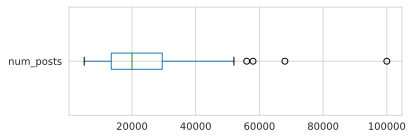

In [27]:
cat_df[['num_posts']].plot(kind='box', vert=False, figsize=(6, 2));

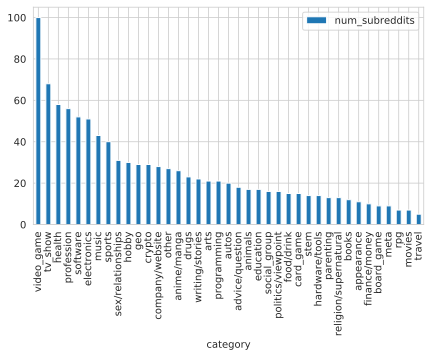

In [28]:
cat_df[['num_subreddits']].plot(kind='bar', figsize=(7,4));

## Eksploracja danych tekstowych - częstotliwość występowania słów

In [29]:
sub_df = df[df['subreddit']=='TheSimpsons']

sub_df[['selftext_clean', 'selftext_nouns']].sample(2)

,selftext_clean,selftext_nouns
757132,"Having a look at the IMDB ratings for Simpsons episodes, 5 episodes have managed to break the 9/10 rating, whilst only 3 episodes have scored below a 6 (with one single episode scoring lower than a 5). Here are the episodes:\n\n> **The best**\n\n* **9.2** *Season 7 Episode 17* **Homer the Smithers**\n* **9.1** *Season 8 Episode 23* **Homer's Enemy**\n* **9.0** *Season 6 Episode 9* **Homer Badman**\n* **9.0** *Season 4 Episode 3* **Homer the Heretic**\n* **9.0** *Season 8 Episode 15* **Homer's Phobia**\n\n> **And the worst**\n\n* **5.5** *Season 13 Episode 17* **Gump Roast**\n* **5.3** *Season 9 Episode 11* **All Singing All Dancing**\n\n> And unsurprisingly, the lowest ever rated episode\n\n* **4.9** *Season 23 Episode 22* **Lisa Goes Gaga**",look IMDB rating Simpsons episode episode rating episode episode episode season Episode smither season Episode Homer Enemy season episode Homer Badman season episode Heretic season Episode Homer Phobia season episode Gump Roast season episode dancing episode season Episode Lisa Gaga
547070,"Does anyone have any information on the over-dubbing in this episode? Specifically these two scenes:\n\n- Homer on Smartline, when he screams, but his physical reaction is calm and talkative\n\n- The first round of Lisa's protest song, the second verse (containing ""umbrellas""), the lyrics do not match her mouth movements\n\nI'm just curious if it is known what was dubbed over and why. Thanks!",information dubbing episode scene Homer Smartline reaction round Lisa protest song verse umbrella lyric mouth movement thank


In [30]:
def my_tokenizer(text):
    return text.split() if text != None else []
tokens = sub_df.selftext_nouns.map(my_tokenizer).sum()
print(tokens[:200])

['episode', 'time', 'other', 'instance', 'proposal', 'Putlocker', 'week', 'tv', 'Bart', 'Thanksgiving', 'episode', 'other', 'show', 'girlfriend', 'kid', 'point', 'go', 'show', 'movie', 'thing', 'reference', 'continuity', 'quality', 'reference', 'back', 'movie', 'season', 'Mr.', 'Burns', 'joke', 'consequence', 'callback', 'order', 'problem', 'quality', 'matching', 'movie', 'lot', 'episode', 'show', 'point', 'season', 'dip', 'movie', 'end', 'cap', 'movie', 'cartooniness', 'vibe', 'show', 'hour', 'episode', 'head', 'while', 'guy', 'hope', 'year', 'Lisa', 'boy', 'school', 'parent', 'creepy', 'stuff', 'episode', 'treehouse', 'horror', 'idea', 'idea', 'episode', 'Elijah', 'Wood', 'guest', 'show', '¯\\', 'ツ', 'post', 'time', 'episode', 'episode', 'Homer', 'City', 'New', 'York', 'season', 'episode', 'Youtube', 'min', 'clip', 'Homer', 'car', 'garage', 'Marge', 'homer', 'chore', 'paper', 'car', 'episode', 'name', 'episode', 'Homer', 'bully', 'Kearney', 'joke', 'Homer', 'line', 'guy', 'thank', 'e

Wyświetlmy sobie najczęściej występujące słowa

In [31]:
from collections import Counter

counter = Counter(tokens)
counter.most_common(20)

[('episode', 1192),
 ('season', 547),
 ('Homer', 545),
 ('Simpsons', 509),
 ('show', 327),
 ('Bart', 320),
 ('time', 221),
 ('character', 214),
 ('scene', 212),
 ('Lisa', 210),
 ('year', 197),
 ('simpson', 196),
 ('Marge', 173),
 ('thing', 141),
 ('joke', 135),
 ('people', 133),
 ('guy', 132),
 ('one', 127),
 ('way', 120),
 ('Simpson', 111)]

In [32]:
df.category.unique()

array(['writing/stories', 'tv_show', 'autos', 'hardware/tools',
       'electronics', 'video_game', 'crypto', 'sports', 'hobby',
       'appearance', 'card_game', 'drugs', 'advice/question',
       'social_group', 'anime/manga', 'sex/relationships', 'software',
       'health', 'other', 'animals', 'arts', 'programming', 'rpg',
       'books', 'parenting', 'education', 'company/website', 'profession',
       'music', 'politics/viewpoint', 'stem', 'travel', 'geo',
       'religion/supernatural', 'board_game', 'movies', 'food/drink',
       'finance/money', 'meta'], dtype=object)

In [33]:
print([t[0] for t in counter.most_common(200)])

['episode', 'season', 'Homer', 'Simpsons', 'show', 'Bart', 'time', 'character', 'scene', 'Lisa', 'year', 'simpson', 'Marge', 'thing', 'joke', 'people', 'guy', 'one', 'way', 'Simpson', 'thank', 'game', 'family', 'day', 'idea', 'fan', 'lot', 'Springfield', 'Burns', 'name', 'line', 'kid', 'homer', 'series', 'help', 'tv', 'life', 'point', 'clip', 'song', 'friend', 'end', 'reason', 'reference', 'moment', 'part', 'quote', 'Moe', 'Episode', 'story', 'Skinner', 'head', 'writer', 'movie', 'car', 'Krusty', 'version', 'place', 'school', 'question', 'man', 'Mr.', 'voice', 'bit', 'Ned', 'dvd', 'example', 'Maggie', 'stuff', 'gag', 'today', 'money', 'Bob', 'Apu', 'quality', 'post', 'person', 'house', 'number', 'list', 'age', 'advance', 'Guy', 'memory', 'plot', 'video', 'face', 'thought', 'Christmas', 'issue', 'Family', 'couch', 'town', 'opinion', 'Flanders', 'future', 'job', 'Season', 'mother', 'other', 'week', 'while', 'Horror', 'commentary', 'case', 'event', 'book', 'world', 'month', 'Halloween', '

In [34]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    return [t for t in tokens if t not in STOP_WORDS]

counter = Counter(remove_stopwords(tokens))

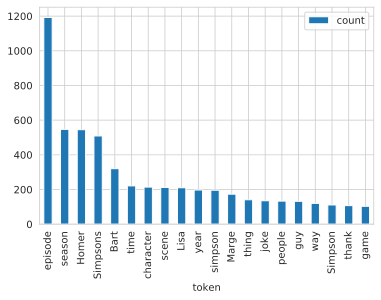

In [35]:
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])
freq_df.plot(kind='bar', x='token');

## Eksploracja danych tekstowych - wizualizacja w postaci chmur słów

Jedną z częściej wykorzystywanych (obok histogramów) metodą wizualizacji wyników eksploracji danych na tekstach są chmury słów. Są to mapy, które pokazują najczęściej występujące słowa w tekście, a rozmiary poszczególnych słów są proporcjonalne do częstotliwości występowania w badanej próbce tekstu. Jedną z bibliotek, która umożliwia tak wygodną prezentację jest biblioteka worldcloud.

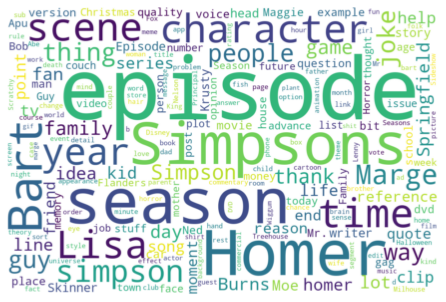

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud(counter):
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    
wordcloud(counter)

Wizualizację można wykonać dla każdego z subredditów osobno lub dla wszystkich danych, które posiadamy. Oto prezentacja w postaci chmury słów dla subreddita thesopranos:

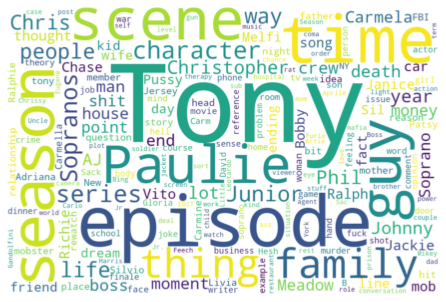

In [38]:
tokens2 = df[df['subreddit']=='thesopranos'].selftext_nouns \
         .map(my_tokenizer).sum()

counter2 = Counter(remove_stopwords(tokens2))
wordcloud(counter2)

Gdzie jeszcze można wykorzystać taką analizę? Na przykład analizując wpisy na blogach czy stronach internetowych - dzięki temu łatwo jest określić słowa kluczowe lub sprawdzić, czy gęstość ich występowania jest wystarczająca. Tego typu praktyki są standardowym podejściem w przypadku tworzenia profesjonalnych artykułów, czy treści, które mają przykuć uwagę czytelnika lub zapaść w jego pamięci.

## Analiza złośoności tekstu

Spróbujemy odpowiedzieć sobie na pytanie, czy złożoność tekstu jest związana z konkretną kategorią, w której tekst się znalazł. Oczywiście - jest to miejsce, gdzie trzeba wprowadzić jakąś miarę złożoności tekstu. Może być nią na przykład liczba znaków poszczególnych słowach lub parametr, który zwany jest indeksem czytelności Flescha. Parametr ten ma na celu określenie stopnia trudności zrozumienia tekstu w języku angielskim. Im indeks jest niższy, tym tekst jest trudniejszy do zrozumienia. Skala zrozumienia tekstu wygląda następująco:

1. wynik 120 - tekst najłatwiejszy, składa się z bardzo prostych zdań (w praktyce dwa jednosylabowe słowa)
2. wynik powyżej 100 - tekst bardzo łatwy do zrozumienia przez dziecko
3. 90 - 100 - tekst łatwy do zrozumienia przez osobę na poziomie ucznia szkoły podstawowej
4. 60 - 70 - tekst łatwy do zrozumienia przez nastolatka
5. 30 - 50 - typowy tekst na poziomie akademickim
6. 0 - 30 - tekst stricte naukowy, trudny do zrozumienia

Typowe teksty, które czytamy w czasopismach mają indeks czytelności Flescha na poziomie 50 - 100 (w zależności od grupy docelowej). Teksty publikowane w najlepszych czasopismach naukowych raczej nie przekraczają wartości 30.

Oczywiście indeks ten nie jest jedyną miarą tego typu. Innym parametrem jest na przykład indeks czytelności FOG. Indeks ten jest również określony dla języka polskiego, a jego wartość wiąże się z liczbą lat edukacji, które należy odbyć, aby zrozumieć tekst. W tym przypadku - prasa codzienna celuje w wartość ok. 6-7 (poziom szkoły podstawowej), prasa specjalistyczna - 15+ (poziom studiów licencjackich), a prasa naukowa ponad 18 (poziom studiów magisterskich i osób z tytułem naukowym).

W naszej analizie skorzystamy z biblioteki textacy, która dostarcza funkcji TextStatus. Naszą miarą skomplikowania tekstu będzie liczba tokenów (a dokładniej brak tokenów), które wytworzone zostały w poprzednich krokach analizy.

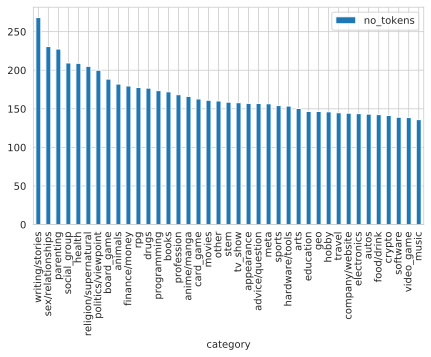

In [39]:
df['no_tokens'] = df.selftext_lemma.map(lambda l: 0 if l==None else len(l.split()))
df.groupby(['category']).agg({'no_tokens':'mean'}).sort_values(by='no_tokens', ascending=False).plot(kind='bar', figsize=(7,4))

Spójrzmy teraz na trochę bardziej zaawansowaną statystykę, niż tylko średnie liczby wpisów bez tokenów. Ułatwimy sobie odrobinę zadanie korzystając z biblioteki seaborn, która stworzy nam wykresy pudełkowe obrazujące więcej informacji.

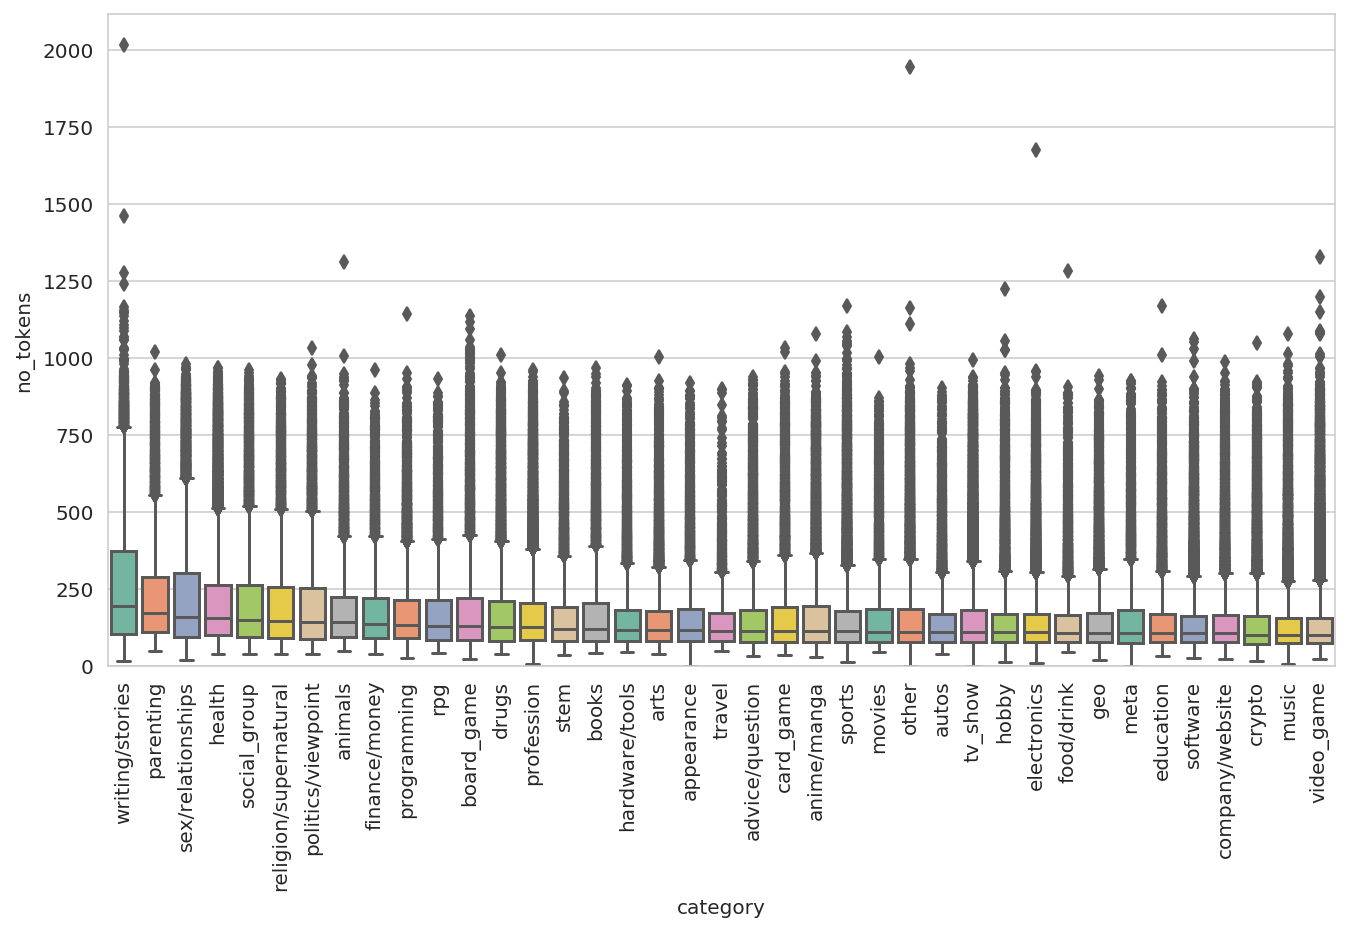

In [40]:
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

def multi_boxplot(data, x, y, ylim = None):
    fig, ax = plt.subplots()
    plt.xticks(rotation=90) 
    
    ordered_values = data.groupby(x)[[y]] \
                         .median() \
                         .sort_values(y, ascending=False) \
                         .index
        
    sns.boxplot(x=x, y=y, data=data, palette='Set2', 
                order=ordered_values)

    fig.set_size_inches(11, 6)
    ax.set_ylim(0, ylim)
    
multi_boxplot(df, 'category', 'no_tokens');

Zobaczmy na punkty odstające od wykresu:

In [41]:
df['selftext_lemma'][df.no_tokens > 1500]

237498    here be a ikev1 site to site tunnel -PRON- have set up . \n\n asa1 \n\n define object * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * \n object network OBJ 172.29.2.0 \n \isubnet 172.29.2.0 \n\n object network OBJ 192.168.80.0 \n \isubnet 192.168.80.0 \n\n NAT exemption * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * \n nat ( inside , outside ) static OBJ 192.168.80.0 OBJ 192.168.80.0 destination static OBJ 172.29.2.0 OBJ 172.29.2.0 \n\n ACL * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * \n access - list MOTIVITY ACL extend permit ip 192.168.80.0 255.255.255.0 172.29.2.0 255.255.255.0 \n access - list MOTIVI

Strasznie dużo śmieci i treści, których można się było spodziewać - reklamy i efekty działania złośliwych botów. Metodę tę można również wykorzystać do czyszczenia niechcianych wpisów na stronach internetowych lub kategoryzacji zawartości skrzynki pocztowej oraz oczyszczenie jej z ewidentnego spamu.

Skupmy się teraz na dolnej części wykresu i przeanalizujmy dane, gdzie no_tokens < 500.

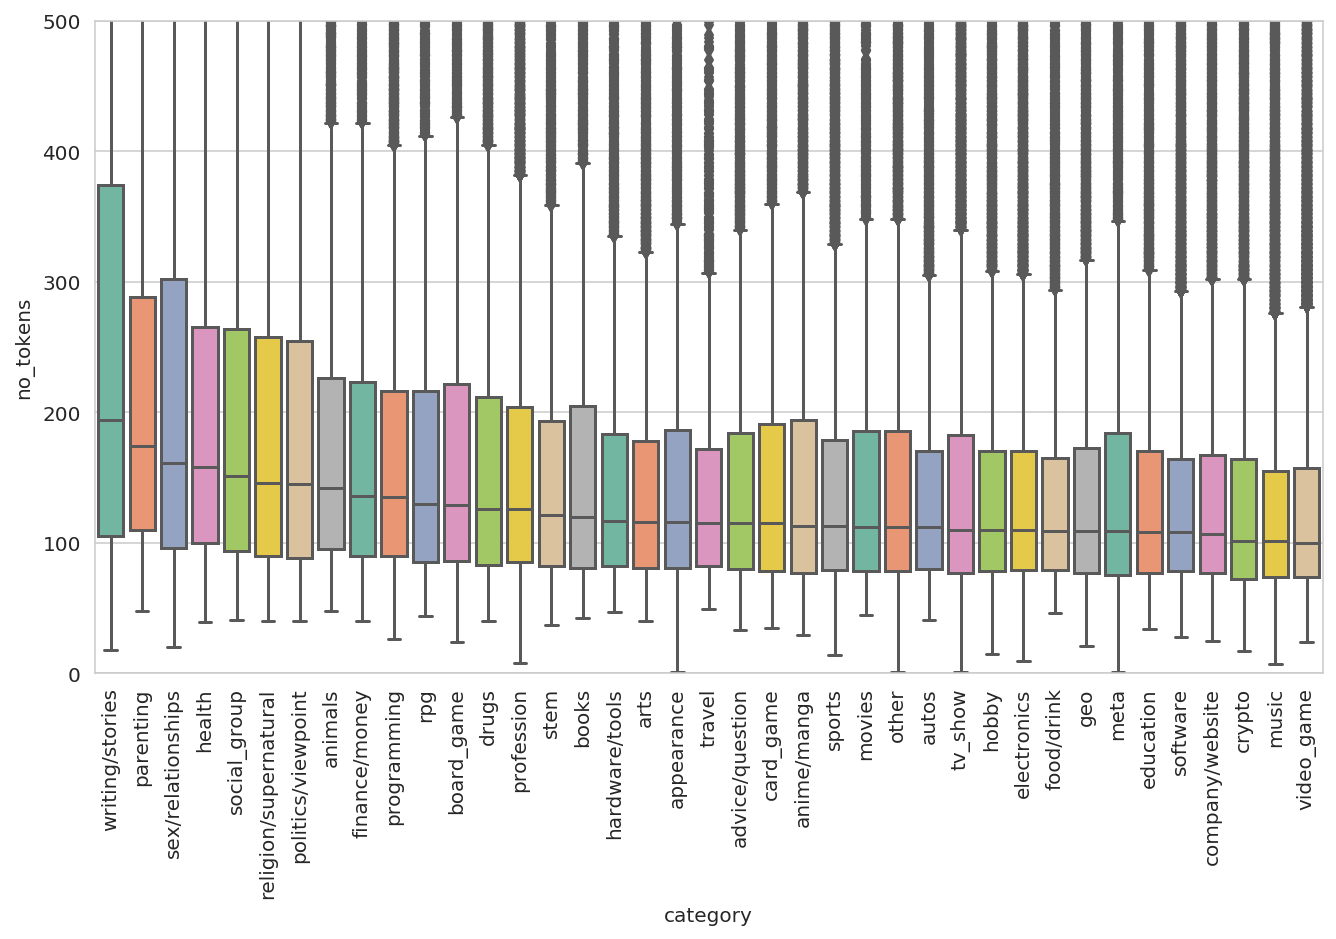

In [42]:
multi_boxplot(df, 'category', 'no_tokens', ylim=500)

Widać, że najbardziej skomplikowane wpisy znajdują się w kategoriach związanych z piśmiennictwem. Wykres pokazuje również, że dyspersja w każdym z subredditów jest do siebie zbliżona, więc podejrzewać można, że dane są rzeczywiste i nie były one tworzone przez boty.

Spójrzmy teraz na pojedyncze kategorie i subreddity w nich zawarte:

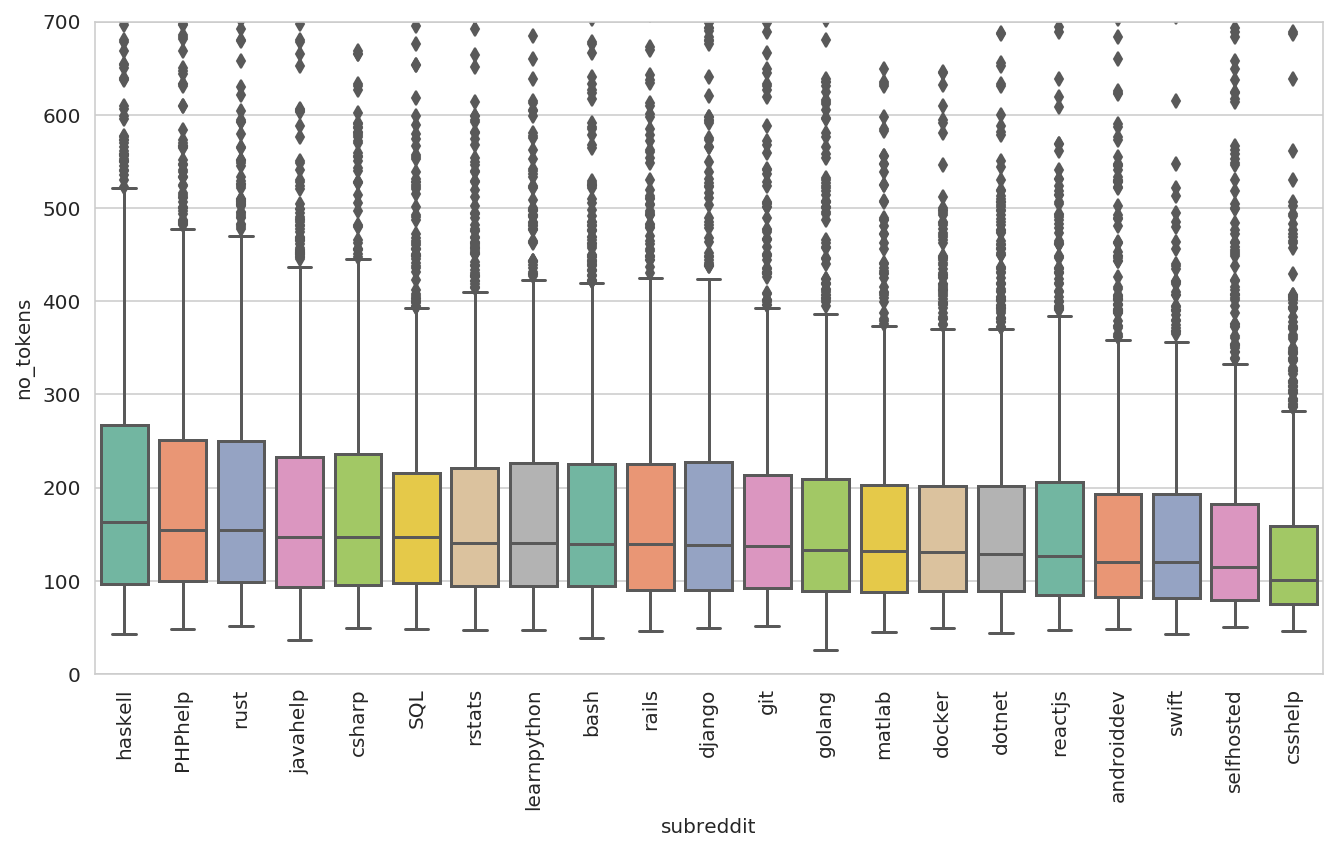

In [43]:
multi_boxplot(df[df.category=='programming'], 'subreddit', 'no_tokens', ylim=700)

Efekt jest bardzo podobny - świetnie widać strukturę wpisów, niepasujące treści i ich statystykę.

## Podsumowanie

Analiza tekstu jest jednym z ciekawszych zagadnień związanych z eksloracją danych. Dodatkowo analiza języka naturalnego jest w dalszym ciągu mało poznaną gałęzią i jest w niej wiele do zrobienia.

Tego typu analizę warto również wykonać dla tekstów stworzonych w różnym czasie (np. autorzy blogów mogą łatwo zobaczyć jak poprawiały się ich zdolności językowe z biegiem czasu lub jak ewoluował język, który wykorzystywali). Zachęcam Państwa do własnych eksperymentów związanych z analizą danych tekstowych.